---
title: "Código básico para un solo paciente"
format: html
---

In [6]:
import numpy as np
import mne
import yasa
import pandas as pd

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Información importante

http://dataset.isr.uc.pt/ISRUC_Sleep/Content.pdf

Pacientes Data of Subgroup_3. Cada comprimido tiene:
* un fichero .rec que es un .edf (RENOMBRARLO)
* dos ficheros .txt que son las marcas de los especialistas
* dos fichero .xlsx que contienen la misma información (Stage) y más (muy útil si se desea profundizar en porqué se cometen los errores, para descartar épocas de dudosa calidad, etc.).

https://sleeptight.isr.uc.pt/?page_id=48

El PSG está compuesto por las señales de los siguientes canales:

-   EEG (F3, C3, O1, F4, C4 y O2);
-   EOG, derecho e izquierdo (ROC y LOC);
-   electrocardiograma (ECG);
-   tipos de EMG (un m. submentalis -- EMG de la barbilla (X1) -- y dos m. tibialis -- EMG de las piernas);
-   Las referencias se colocaron en los lóbulos de las orejas izquierda y derecha (A1, A2).


# Canales del polisomnograma

In [9]:
path = '../dataset/1/1.edf' #camino al fichero del paciente 1
raw = mne.io.read_raw_edf(path, preload=True)
#Eliminamos los canales que no queremos, CUIDADO CON QUITAR MUCHOS CANALES PORQUE DESPUÉS NO HAY INTERPRETACIÓN CLÍNICA
raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8','ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1','O2-A1', 'X2', 'X3' ])
#Cambiamos la frecuencia a 100 Hz para reducir el tiempo de cálculo (aprovechamos que no tenemos frecuencias superiores a 50Hz de interés)
raw.resample(100)
#Filtramos la señal para eliminar la línea basal (f muy bajas producidas por la respiración, movimiento de piernas, etc.) 
raw.filter(0.3, 49)

# Observamos los datos
sf = raw.info['sfreq']
chan = raw.ch_names
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
#CUIDADO! si se accede directamente a los datos hay que cambiar la escala!
data = raw.get_data() * 1e6 #microVolts (porque mne trabaja en V)
data = data[:,:-30*30*100] #eliminamos las 30 últimas porque lo indica el artículo de referencia
print('Data shape =', data.shape)


Extracting EDF parameters from /home/julian/info/Uni/health/sleep-stage-detection/dataset/1/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Chan = ['LOC-A2', 'C4-A1', 'X1']
Sampling frequency = 100.0 Hz
Data shape = (3, 2772000)


# Etiquetas Fases

CODIFICACIÓN DE LAS FASES EN LOS FICHEROS DE ISRUC-SLEEP Dataset (cuidado porque no hay valor 4 (antiguamente se distinguía una fase más))

* TXT->STAGE
* 0->W
* 1->N1
* 2->N2
* 3->N3
* 5->REM

The default hypnogram format in YASA is a 1D integer vector where:
    
* -2 = Unscored
* -1 = Artefact / Movement
* 0 = Wake
* 1 = N1 sleep
* 2 = N2 sleep
* 3 = N3 sleep
* 4 = REM sleep

In [10]:
#Cargamos las etiquetas del primer médico y eliminamos las 30 por que lo indica el artículo 
path_lab='../dataset/1/1_1.txt'  #camino a las etiquetas de marcado del clínico 1
labels1 = pd.read_csv(path_lab, header = None).squeeze("columns")
labels1[labels1==5]=4 #cuidado con la codificación si se quiere utilizar las funciones de YASA... 
labels1 = labels1[:-30]

# Características 

Generamos un registro por cada 30 segundos de polisomnograma. La función SleepStaging realiza esta tarea pero genera las características que considera el autor de la librería. 

In [11]:
#Obtenemos algunas características utilizando la función SleepStaging
sls = yasa.SleepStaging(raw, eeg_name ='C4-A1' ,  eog_name='LOC-A2', emg_name='X1')
#Eliminamos las 30 últimas épocas
sls2 = sls.get_features()[:-30]

sls_train = sls2 
label_train = labels1

In [22]:
sls_train

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,2.223068,0.204966,0.002076,0.306459,0.378508,0.849507,4.183846,0.938656,2.029363,0.126726,...,-0.455231,-0.522732,3.658173,1.719663,2.068285,0.027003,-0.753603,-0.772851,0.000000,0.000000
1,1.739309,0.187676,-0.035666,0.214499,0.363193,0.644535,1.858936,0.838479,1.347365,0.142990,...,-0.423155,-0.290970,2.873480,1.567306,1.747598,0.048089,-0.751319,-0.699733,0.008333,0.001049
2,10.646273,0.178649,0.415034,0.053756,0.354735,0.337353,1.102060,0.774777,0.972015,0.103112,...,-0.404205,-0.154302,3.556994,1.419040,1.826927,0.042671,-0.753057,-0.687887,0.016667,0.002099
3,3.218050,0.118178,0.350609,0.125759,0.373581,0.264007,1.339224,0.733314,0.819126,0.195343,...,-0.415448,-0.320513,2.967387,1.242866,1.746112,0.048401,-0.756539,-0.672028,0.025000,0.003148
4,1.839396,0.060042,0.335642,0.145482,0.400621,0.084603,1.453737,0.701424,0.418695,0.268479,...,-0.398635,-0.135475,2.672432,1.056105,1.544686,0.039588,-0.762816,-0.650208,0.033333,0.004197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2.524090,0.033917,0.055975,0.134543,0.103611,0.145533,1.014649,0.048055,0.122882,0.021427,...,-0.121702,-0.459255,0.921858,-0.282974,-0.199064,0.166737,0.271807,0.289422,7.658333,0.964323
920,2.771756,0.036724,0.059561,0.092007,0.083935,0.091201,0.501127,0.024840,0.046030,0.017454,...,-0.123688,-0.279334,0.828926,-0.275030,-0.221170,0.133691,0.262854,0.191211,7.666667,0.965373
921,2.899317,0.032813,0.069646,0.150544,0.070789,0.105381,0.730379,0.008089,0.054634,0.017320,...,-0.095145,-0.154362,0.962611,-0.267876,-0.195073,0.172972,0.260648,0.185463,7.675000,0.966422


# Modelo 

Modelo multiclase sin ajuste de parámetros, ni validación ni generalización. 

In [7]:
X_train= sls_train[:]
y_train= label_train[:]

# Binarize the output
y_train = label_binarize(y_train, classes=[0, 1, 2, 3, 4])
n_classes = 5
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
     RandomForestClassifier(n_estimators=1000, criterion="gini", random_state=0)
)
classifier.fit(X_train, y_train)

rf = []
rf.append(classifier)
y_score_train = classifier.predict_proba(X_train)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc_train = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_train[:, i], y_score_train[:, i])
    roc_auc_train[i] = auc(fpr[i], tpr[i])

In [8]:
roc_auc_train

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

# My code

---

In [47]:
# Compare labels from two doctors

txt_paths = [f"../dataset/{i}/{i}_1.txt" for i in range(1, 11)]

labels1_list = []

for txt in txt_paths:
    labels1 = pd.read_csv(path_lab, header = None).squeeze("columns")
    labels1[labels1==5]=4
    labels1 = labels1[:-30]
    labels1_list.append(labels1)

labels1 = pd.concat(labels1_list, axis=0, ignore_index=True)

txt_paths = [f"../dataset/{i}/{i}_2.txt" for i in range(1, 11)]

labels2_list = []

for txt in txt_paths:
    labels2 = pd.read_csv(path_lab, header = None).squeeze("columns")
    labels2[labels2==5]=4
    labels2 = labels2[:-30]
    labels2_list.append(labels2)

labels2 = pd.concat(labels1_list, axis=0, ignore_index=True)


total_labels = len(labels1)
num_matches = sum(np.array(labels1) == np.array(labels2))
num_differences = total_labels - num_matches
agreement_percentage = (num_matches / total_labels) * 100

print(f"Total Labels: {total_labels}")
print(f"Number of Matches: {num_matches}")
print(f"Number of Differences: {num_differences}")
print(f"Agreement Percentage: {agreement_percentage:.2f}%")


Total Labels: 9240
Number of Matches: 9240
Number of Differences: 0
Agreement Percentage: 100.00%


In [49]:
edf_paths = [f"../dataset/{i}/{i}.edf" for i in range(1, 11)]

data_list = []
i=1

for path in edf_paths:
    raw = mne.io.read_raw_edf(path, preload=True)
    raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'O2-A1', 'X2', 'X3'])
    raw.resample(100)
    raw.filter(0.3, 49)
    sls = yasa.SleepStaging(raw, eeg_name ='C4-A1' ,  eog_name='LOC-A2', emg_name='X1')
    sls2 = sls.get_features()[:-30] 
    sls2['patient'] = i
    data_list.append(sls2)
    i+=1

Extracting EDF parameters from /home/julian/info/Uni/health/sleep-stage-detection/dataset/1/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Extracting EDF parameters from /home/julian/info/Uni/health/sleep-stage-detection/dataset/2/2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 

In [51]:
df = pd.concat(data_list, axis=0, ignore_index=True)
df['label'] = labels1


In [52]:
df

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm,patient,label
0,2.223068,0.204966,0.002076,0.306459,0.378508,0.849507,4.183846,0.938656,2.029363,0.126726,...,3.658173,1.719663,2.068285,0.027003,-0.753603,-0.772851,0.000000,0.000000,1,0
1,1.739309,0.187676,-0.035666,0.214499,0.363193,0.644535,1.858936,0.838479,1.347365,0.142990,...,2.873480,1.567306,1.747598,0.048089,-0.751319,-0.699733,0.008333,0.001049,1,0
2,10.646273,0.178649,0.415034,0.053756,0.354735,0.337353,1.102060,0.774777,0.972015,0.103112,...,3.556994,1.419040,1.826927,0.042671,-0.753057,-0.687887,0.016667,0.002099,1,0
3,3.218050,0.118178,0.350609,0.125759,0.373581,0.264007,1.339224,0.733314,0.819126,0.195343,...,2.967387,1.242866,1.746112,0.048401,-0.756539,-0.672028,0.025000,0.003148,1,0
4,1.839396,0.060042,0.335642,0.145482,0.400621,0.084603,1.453737,0.701424,0.418695,0.268479,...,2.672432,1.056105,1.544686,0.039588,-0.762816,-0.650208,0.033333,0.004197,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,1.689531,0.083630,0.166005,0.054617,0.042170,-0.040508,0.309166,-0.037917,-0.024846,0.012473,...,1.162780,-0.044361,-0.024150,0.124126,0.052475,0.035126,6.341667,0.957233,10,2
8585,0.827841,0.060448,0.132634,0.112396,0.080795,0.005466,0.447176,-0.022316,-0.102220,0.037533,...,0.938274,-0.043509,-0.029735,0.265009,0.063362,0.196317,6.350000,0.958491,10,2
8586,0.969841,0.041204,0.110130,0.066259,0.106981,-0.059442,0.373438,-0.005168,-0.185313,0.023099,...,0.980872,-0.038315,-0.041812,0.135848,0.042102,0.174866,6.358333,0.959748,10,2
8587,1.027211,0.025514,0.078914,0.126245,0.131536,0.155500,0.877514,0.014709,0.090224,0.084172,...,2.469572,0.011695,0.080303,0.053560,0.012319,0.027808,6.366667,0.961006,10,2


In [89]:
df_train = df[df['patient'].between(1, 8)]
df_test = df[df['patient'].between(9, 10)]

In [90]:
from sklearn.ensemble import HistGradientBoostingClassifier

y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

y_test = df_test['label']
X_test = df_test.drop(columns=['label'])

clf = HistGradientBoostingClassifier().fit(X_train, y_train)

df_test['preds'] = clf.predict(X_test)

/tmp/ipykernel_548991/1661861966.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = clf.predict(X_test)


In [91]:
df_test['preds']


6884    2
6885    2
6886    2
6887    2
6888    3
       ..
8584    2
8585    2
8586    2
8587    2
8588    2
Name: preds, Length: 1705, dtype: int64

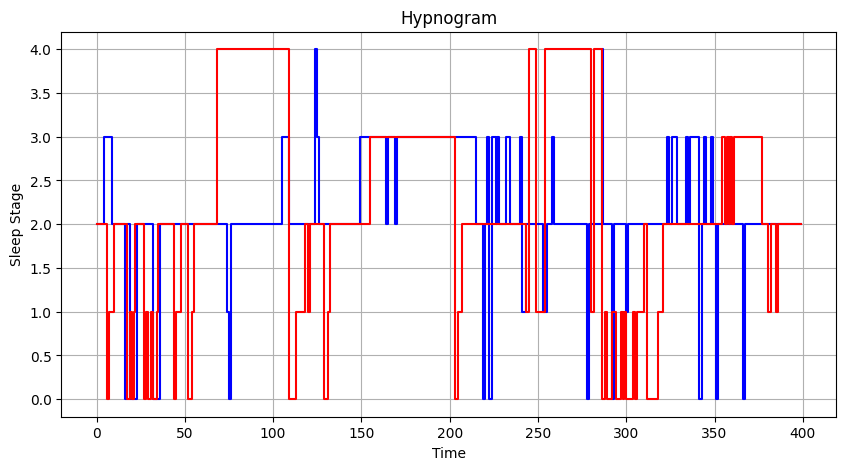

In [96]:
import matplotlib.pyplot as plt

time = np.arange(len(df_test[:400]))

# sleep_stages = {0: "Wake", 1: "N1 sleep", 2: "N2 sleep", 3: "N3 sleep", 4: "REM sleep"}

#df_test['preds'] = df_test['preds'].map(sleep_stages)

# Visualisierung des Hypnogramms
plt.figure(figsize=(10, 5))
plt.plot(time, df_test['preds'][:400], drawstyle='steps-post', color='b')
plt.plot(time, df_test['label'][:400], drawstyle='steps-post', color='r')


# Achsen anpassen
# plt.yticks(np.arange(len(sleep_stages)), list(sleep_stages.values()))
plt.xlabel('Intervals')
plt.ylabel('Sleep Stage')
plt.title('Hypnogram')

plt.grid(True)
plt.show()

In [97]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# Binarisiere die Labels für die AUC-Berechnung (One-vs-Rest)
y_true_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(df_test['preds'], classes=[0, 1, 2, 3, 4])

# Berechne F1-Score für jede Klasse (durchschnittlich über alle Klassen)
f1_scores = f1_score(y_test, df_test['preds'], average=None, labels=[0, 1, 2, 3, 4])
print("F1-Score für jede Klasse:", f1_scores)

# Berechne Recall für jede Klasse
recall_scores = recall_score(y_test, df_test['preds'], average=None, labels=[0, 1, 2, 3, 4])
print("Recall für jede Klasse:", recall_scores)

# Berechne AUC für jede Klasse (One-vs-Rest)
auc_scores = roc_auc_score(y_true_bin, y_pred_bin, average=None, multi_class='ovr')
print("AUC für jede Klasse:", auc_scores)

# Durchschnittswerte für F1-Score, Recall und AUC (optional)
print("Durchschnittlicher F1-Score:", f1_scores.mean())
print("Durchschnittlicher Recall:", recall_scores.mean())
print("Durchschnittliche AUC:", auc_scores.mean())

F1-Score für jede Klasse: [0.0596206  0.05577689 0.49697581 0.22614841 0.00833333]
Recall für jede Klasse: [0.03492063 0.03349282 0.73692078 0.2        0.00520833]
AUC für jede Klasse: [0.50199269 0.50504855 0.47174224 0.53429603 0.48707211]
Durchschnittlicher F1-Score: 0.169371007663036
Durchschnittlicher Recall: 0.20210851369999938
Durchschnittliche AUC: 0.5000303248064069


In [118]:
edf_paths = [f"../dataset/{i}/{i}.edf" for i in range(9, 11)]

preds_list = []

for path in edf_paths:
    raw = mne.io.read_raw_edf(path, preload=True)
    raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'O2-A1', 'X2', 'X3'])
    raw.resample(100)
    raw.filter(0.3, 49)
    sls = yasa.SleepStaging(raw, eeg_name ='C4-A1' ,  eog_name='LOC-A2', emg_name='X1')
    preds_list = yasa.hypno_str_to_int(sls.predict()[:-30])

df_test['preds_sls'] = preds_list

Extracting EDF parameters from /home/julian/info/Uni/health/sleep-stage-detection/dataset/9/9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Extracting EDF parameters from /home/julian/info/Uni/health/sleep-stage-detection/dataset/10/10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 

/home/julian/info/Uni/health/sleep-stage-detection/.venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)



/home/julian/info/Uni/health/sleep-stage-detection/.venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Length of values (766) does not match length of index (1705)

In [113]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# Binarisiere die Labels für die AUC-Berechnung (One-vs-Rest)
y_true_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

# Berechne F1-Score für jede Klasse (durchschnittlich über alle Klassen)
f1_scores = f1_score(y_test, pred, average=None, labels=[0, 1, 2, 3, 4])
print("F1-Score für jede Klasse:", f1_scores)

# Berechne Recall für jede Klasse
recall_scores = recall_score(y_test, pred, average=None, labels=[0, 1, 2, 3, 4])
print("Recall für jede Klasse:", recall_scores)

# Berechne AUC für jede Klasse (One-vs-Rest)
auc_scores = roc_auc_score(y_true_bin, y_pred_bin, average=None, multi_class='ovr')
print("AUC für jede Klasse:", auc_scores)

# Durchschnittswerte für F1-Score, Recall und AUC (optional)
print("Durchschnittlicher F1-Score:", f1_scores.mean())
print("Durchschnittlicher Recall:", recall_scores.mean())
print("Durchschnittliche AUC:", auc_scores.mean())

F1-Score für jede Klasse: [0.26039783 0.11458333 0.41351569 0.07807808 0.0755814 ]
Recall für jede Klasse: [0.45714286 0.10526316 0.38415546 0.040625   0.06770833]
AUC für jede Klasse: [0.49583762 0.50149522 0.53908545 0.5203125  0.48791894]
Durchschnittlicher F1-Score: 0.18843126492606058
Durchschnittlicher Recall: 0.21097896085505244
Durchschnittliche AUC: 0.508929943907111


In [121]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Prepare the training and testing data
y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

y_test = df_test['label']
X_test = df_test.drop(columns=['label']).drop(columns=['preds'])

# Initialize the XGBClassifier and fit the model
clf = xgb.XGBClassifier(num_class=5, objective='multi:softmax', eval_metric='mlogloss').fit(X_train, y_train)

# Make predictions
df_test['preds_xgb'] = clf.predict(X_test)

# Optionally, check the accuracy of the model
accuracy = accuracy_score(y_test, df_test['preds_xgb'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3648


/tmp/ipykernel_548991/2603969580.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds_xgb'] = clf.predict(X_test)


In [122]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# Binarisiere die Labels für die AUC-Berechnung (One-vs-Rest)
y_true_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(df_test['preds_xgb'], classes=[0, 1, 2, 3, 4])

# Berechne F1-Score für jede Klasse (durchschnittlich über alle Klassen)
f1_scores = f1_score(y_test, df_test['preds_xgb'], average=None, labels=[0, 1, 2, 3, 4])
print("F1-Score für jede Klasse:", f1_scores)

# Berechne Recall für jede Klasse
recall_scores = recall_score(y_test, df_test['preds_xgb'], average=None, labels=[0, 1, 2, 3, 4])
print("Recall für jede Klasse:", recall_scores)

# Berechne AUC für jede Klasse (One-vs-Rest)
auc_scores = roc_auc_score(y_true_bin, y_pred_bin, average=None, multi_class='ovr')
print("AUC für jede Klasse:", auc_scores)

# Durchschnittswerte für F1-Score, Recall und AUC (optional)
print("Durchschnittlicher F1-Score:", f1_scores.mean())
print("Durchschnittlicher Recall:", recall_scores.mean())
print("Durchschnittliche AUC:", auc_scores.mean())

F1-Score für jede Klasse: [0.07352941 0.07220217 0.54409567 0.18363273 0.04608295]
Recall für jede Klasse: [0.04761905 0.04784689 0.8161435  0.14375    0.02604167]
AUC für jede Klasse: [0.49575197 0.50453842 0.52583237 0.52313854 0.50641145]
Durchschnittlicher F1-Score: 0.183908585368256
Durchschnittlicher Recall: 0.21628022039914302
Durchschnittliche AUC: 0.5111345481285291


In [123]:
# Zähle die Anzahl der verschiedenen 'label'-Werte im DataFrame
label_counts = df_train['label'].value_counts()

print(label_counts)


label
2    2722
3    1356
0    1243
1     846
4     717
Name: count, dtype: int64
